# RL Figure: 2D-Turb-Time + Filters

In [3]:
using JLD2, Interpolations, Statistics, ForwardDiff, OrdinaryDiffEq

const n = 512 # grid resolution 
const L = 2π  # domain length    
const t_step = 0.005 # time-step of DNS data
const frame_max=1230 # number of frames         

##### Load Velocity Field #####
file = jldopen("../../Data Generation/2d-turb-data.jld")
u_data = file["vel_x"]
v_data = file["vel_y"]
vort_data = file["vort"]
close(file)

##### Interpolations #####
itp_vort = interpolate(vort_data, BSpline(Linear(Periodic())))
itp_u = interpolate(u_data, BSpline(Linear(Periodic())))
itp_v = interpolate(v_data, BSpline(Linear(Periodic())))

etp_vort = extrapolate(itp_vort, Periodic())
etp_u = extrapolate(itp_u, Periodic())
etp_v = extrapolate(itp_v, Periodic())

function vort(x,y,t)
    if (t<0)||(t>(frame_max-1)*t_step)
        return 0
    else
        return etp_vort(n*x/L+1, n*y/L+1, t/t_step+1)
    end
end

function velX(x,y,t)
    if (t<0)||(t>(frame_max-1)*t_step)
        return 0
    else
        return etp_u(n*x/L+1, n*y/L+1, t/t_step+1)
    end
end

function velY(x,y,t)
    if (t<0)||(t>(frame_max-1)*t_step)
        return 0
    else
        return etp_v(n*x/L+1, n*y/L+1, t/t_step+1)
    end
end

N_tile = 30 
δ = L/N_tile # grid size for tiling

xA = 1.4 # start point
yA = 3.0 
rA = 0.2

xB = 5.2 # finish point
yB = 1.8
rB = 0.2

u0 = maximum(sqrt.(u_data[:,:,1].^2+v_data[:,:,1].^2)) # background maximum velocity
Va = 0.3*u0 # agent's velocity
Δt = δ/(2*u0) # agent's reaction time
Na = 8 # number of actions

n_episodes = 5000 # number of episodes for evaluation
n_train = 100000 # number of episodes for training

T_free = sqrt((xB-xA)^2+(yB-yA)^2)/Va
T_max = 5*T_free

w_reward = 1.0 # weight in the reward function

# optimal trajectory

##### Derivatives #####
velX_x(x,y,t) = ForwardDiff.derivative(z -> velX(z, y, t), x)
velX_y(x,y,t) = ForwardDiff.derivative(z -> velX(x, z, t), y)
velY_x(x,y,t) = ForwardDiff.derivative(z -> velY(z, y, t), x)
velY_y(x,y,t) = ForwardDiff.derivative(z -> velY(x, z, t), y)

function TURB_advection!(du, u, p, t)
    x, y, z = u
    T = p[2]
    du[1] = dx = T*velX(x,y,t*T) + Va*T*cos(z)
    du[2] = dy = T*velY(x,y,t*T) + Va*T*sin(z)
    du[3] = dz = T*(velY_x(x,y,t*T)*sin(z)*sin(z) - velX_y(x,y,t*T)*cos(z)*cos(z) + sin(z)*cos(z)*(velX_x(x,y,t*T)-velY_y(x,y,t*T)))
end

# Simulation interval and intermediary points
tspan = (0.0, 1.0)
tsteps = 0.0:0.001:1.0

p_opt = [-0.06496772807377783, 0.7000008854088864]
prob_opt = ODEProblem(TURB_advection!, [xA, yA, p_opt[1]], tspan, p_opt)
opt_solution = solve(prob_opt, p = p_opt, saveat = tsteps, reltol = 1e-16, abstol = 1e-16)

# points for optimal track
x_opt = []
y_opt = []

T = p_opt[2]

for i in 0:floor(Int, T/Δt)
    x_now, y_now = opt_solution(i*Δt/T)[1], opt_solution(i*Δt/T)[2]
    push!(x_opt, x_now)
    push!(y_opt, y_now)
end

nothing

In [4]:
##### Load Filtered Velocity Field #####
file_filt_10 = jldopen("../../Data Generation/2d-turb-data-filter-k10.jld")
u_data_filt_10 = file_filt_10["vel_x"][:,:,200]
v_data_filt_10 = file_filt_10["vel_y"][:,:,200]
vort_data_filt_10 = file_filt_10["vort"][:,:,200]
close(file_filt_10)

itp_vort_filt_10 = interpolate(vort_data_filt_10, BSpline(Linear(Periodic())))
itp_u_filt_10 = interpolate(u_data_filt_10, BSpline(Linear(Periodic())))
itp_v_filt_10 = interpolate(v_data_filt_10, BSpline(Linear(Periodic())))

etp_vort_filt_10 = extrapolate(itp_vort_filt_10, Periodic())
etp_u_filt_10 = extrapolate(itp_u_filt_10, Periodic())
etp_v_filt_10 = extrapolate(itp_v_filt_10, Periodic())

vort_filt_10(x,y) = etp_vort_filt_10(n*x/L+1, n*y/L+1)
velX_filt_10(x,y) = etp_u_filt_10(n*x/L+1, n*y/L+1)
velY_filt_10(x,y) = etp_v_filt_10(n*x/L+1, n*y/L+1)

#############

file_filt_5 = jldopen("../../Data Generation/2d-turb-data-filter-k5.jld")
u_data_filt_5 = file_filt_5["vel_x"][:,:,200]
v_data_filt_5 = file_filt_5["vel_y"][:,:,200]
vort_data_filt_5 = file_filt_5["vort"][:,:,200]
close(file_filt_5)

itp_vort_filt_5 = interpolate(vort_data_filt_5, BSpline(Linear(Periodic())))
itp_u_filt_5 = interpolate(u_data_filt_5, BSpline(Linear(Periodic())))
itp_v_filt_5 = interpolate(v_data_filt_5, BSpline(Linear(Periodic())))

etp_vort_filt_5 = extrapolate(itp_vort_filt_5, Periodic())
etp_u_filt_5 = extrapolate(itp_u_filt_5, Periodic())
etp_v_filt_5 = extrapolate(itp_v_filt_5, Periodic())

vort_filt_5(x,y) = etp_vort_filt_5(n*x/L+1, n*y/L+1)
velX_filt_5(x,y) = etp_u_filt_5(n*x/L+1, n*y/L+1)
velY_filt_5(x,y) = etp_v_filt_5(n*x/L+1, n*y/L+1)

#############

file_filt_3 = jldopen("../../Data Generation/2d-turb-data-filter-k3.jld")
u_data_filt_3 = file_filt_3["vel_x"][:,:,200]
v_data_filt_3 = file_filt_3["vel_y"][:,:,200]
vort_data_filt_3 = file_filt_3["vort"][:,:,200]
close(file_filt_3)

itp_vort_filt_3 = interpolate(vort_data_filt_3, BSpline(Linear(Periodic())))
itp_u_filt_3 = interpolate(u_data_filt_3, BSpline(Linear(Periodic())))
itp_v_filt_3 = interpolate(v_data_filt_3, BSpline(Linear(Periodic())))

etp_vort_filt_3 = extrapolate(itp_vort_filt_3, Periodic())
etp_u_filt_3 = extrapolate(itp_u_filt_3, Periodic())
etp_v_filt_3 = extrapolate(itp_v_filt_3, Periodic())

vort_filt_3(x,y) = etp_vort_filt_3(n*x/L+1, n*y/L+1)
velX_filt_3(x,y) = etp_u_filt_3(n*x/L+1, n*y/L+1)
velY_filt_3(x,y) = etp_v_filt_3(n*x/L+1, n*y/L+1)

#############

file_filt_2 = jldopen("../../Data Generation/2d-turb-data-filter-k2.jld")
u_data_filt_2 = file_filt_2["vel_x"][:,:,200]
v_data_filt_2 = file_filt_2["vel_y"][:,:,200]
vort_data_filt_2 = file_filt_2["vort"][:,:,200]
close(file_filt_2)

itp_vort_filt_2 = interpolate(vort_data_filt_2, BSpline(Linear(Periodic())))
itp_u_filt_2 = interpolate(u_data_filt_2, BSpline(Linear(Periodic())))
itp_v_filt_2 = interpolate(v_data_filt_2, BSpline(Linear(Periodic())))

etp_vort_filt_2 = extrapolate(itp_vort_filt_2, Periodic())
etp_u_filt_2 = extrapolate(itp_u_filt_2, Periodic())
etp_v_filt_2 = extrapolate(itp_v_filt_2, Periodic())

vort_filt_2(x,y) = etp_vort_filt_2(n*x/L+1, n*y/L+1)
velX_filt_2(x,y) = etp_u_filt_2(n*x/L+1, n*y/L+1)
velY_filt_2(x,y) = etp_v_filt_2(n*x/L+1, n*y/L+1)

nothing

In [5]:
# load data from files
using JLD2

q_data_10 = jldopen("../Q-learning/Q_data_time_filter_k10.jld2")
ac_data_10 = jldopen("../Actor-Critic/AC_data_time_filter_k10.jld2")

q_data_5 = jldopen("../Q-learning/Q_data_time_filter_k5.jld2")
ac_data_5 = jldopen("../Actor-Critic/AC_data_time_filter_k5.jld2")

q_data_3 = jldopen("../Q-learning/Q_data_time_filter_k3.jld2")
ac_data_3 = jldopen("../Actor-Critic/AC_data_time_filter_k3.jld2")

q_data_2 = jldopen("../Q-learning/Q_data_time_filter_k2.jld2")
ac_data_2 = jldopen("../Actor-Critic/AC_data_time_filter_k2.jld2")

nothing

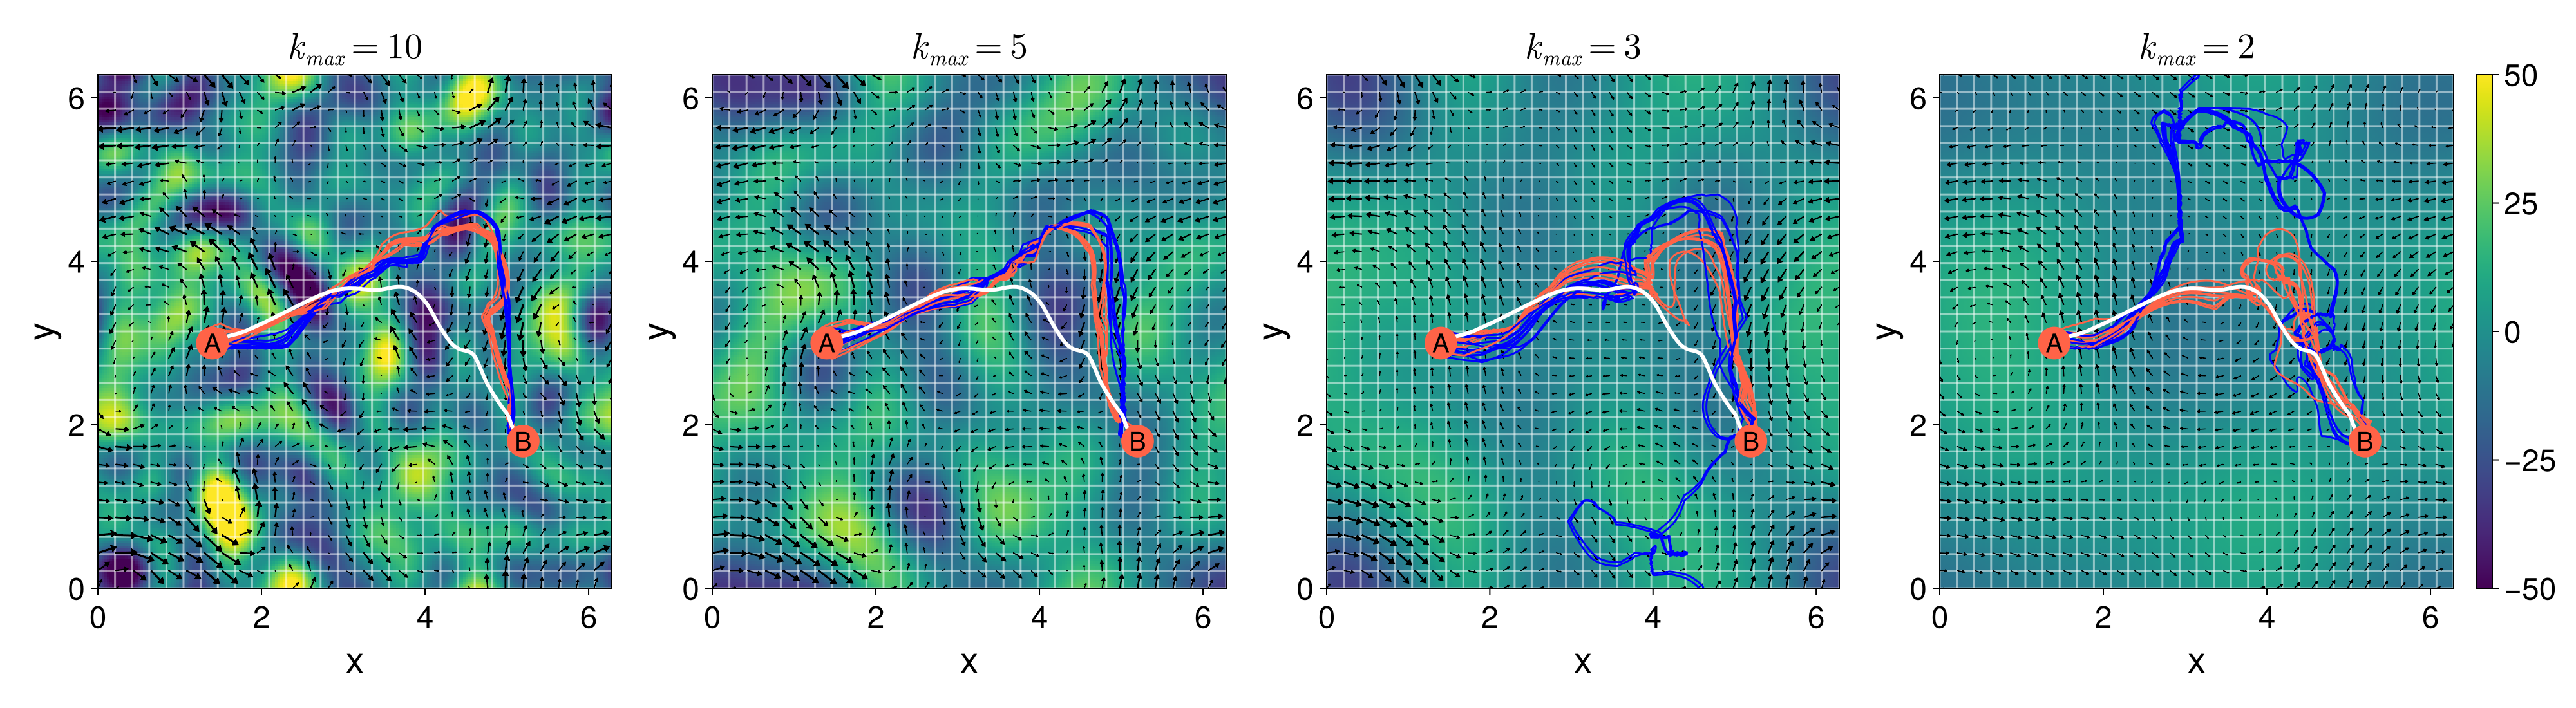

In [6]:
using CairoMakie, LaTeXStrings

fig = Figure(size = (2000, 550), fontsize=24)

xs = range(0, L, length=200)
ys = range(0, L, length=200)
zs = [vort_filt_10(x,y) for x in xs, y in ys]

xs2 = LinRange(0, L, N_tile)
ys2 = LinRange(0, L, N_tile)
us2 = [velX_filt_10(x,y) for x in xs2, y in ys2]
vs2 = [velY_filt_10(x,y) for x in xs2, y in ys2]

ax1 = Axis(fig[1, 1], title=L"k_{max}=10", titlesize=28,
    xlabel = "x", xlabelsize=28, xticklabelsize=24,
    ylabel = "y", ylabelsize=28, yticklabelsize=24,
    aspect = 1, limits = ((0, L), (0, L)), xticks=[0,2,4,6], yticks=[0,2,4,6]
)

hm = heatmap!(ax1, xs, ys, zs, colorrange=(-50, 50), colormap = :viridis, alpha=1.0)

hlines!(ax1, LinRange(0, L, N_tile+1), color=:white, alpha=0.5)
vlines!(ax1, LinRange(0, L, N_tile+1), color=:white, alpha=0.5)

arrows2d!(ax1, xs2, ys2, us2, vs2, lengthscale = 0.02, tiplength=4, tipwidth=6,
            shaftwidth=1.5)

for i in 1:10
    lines!(ax1, q_data_10["x_tracks_EV"][i], q_data_10["y_tracks_EV"][i], color=:tomato)
    lines!(ax1, ac_data_10["x_tracks_EV"][i], ac_data_10["y_tracks_EV"][i], color=:blue)
end

lines!(ax1, x_opt, y_opt, color=:white, linewidth=3)

poly!(ax1, Circle(Point2f(xA, yA), rA), color = :tomato)
text!(xA, yA, text = "A", align = (:center, :center), fontsize=20)

poly!(ax1, Circle(Point2f(xB, yB), rB), color = :tomato)
text!(xB, yB, text = "B", align = (:center, :center), fontsize=20)

####################################

xs = range(0, L, length=200)
ys = range(0, L, length=200)
zs = [vort_filt_5(x,y) for x in xs, y in ys]

xs2 = LinRange(0, L, N_tile)
ys2 = LinRange(0, L, N_tile)
us2 = [velX_filt_5(x,y) for x in xs2, y in ys2]
vs2 = [velY_filt_5(x,y) for x in xs2, y in ys2]

ax2 = Axis(fig[1, 2], title=L"k_{max}=5", titlesize=28,
    xlabel = "x", xlabelsize=28, xticklabelsize=24,
    ylabel = "y", ylabelsize=28, yticklabelsize=24,
    aspect = 1, limits = ((0, L), (0, L)), xticks=[0,2,4,6], yticks=[0,2,4,6]
)

hm = heatmap!(ax2, xs, ys, zs, colorrange=(-50, 50), colormap = :viridis, alpha=1.0)

hlines!(ax2, LinRange(0, L, N_tile+1), color=:white, alpha=0.5)
vlines!(ax2, LinRange(0, L, N_tile+1), color=:white, alpha=0.5)

arrows2d!(ax2, xs2, ys2, us2, vs2, lengthscale = 0.02, tiplength=4, tipwidth=6,
            shaftwidth=1.5)

for i in 1:10
    lines!(ax2, q_data_5["x_tracks_EV"][i], q_data_5["y_tracks_EV"][i], color=:tomato)
    lines!(ax2, ac_data_5["x_tracks_EV"][i], ac_data_5["y_tracks_EV"][i], color=:blue)
end

lines!(ax2, x_opt, y_opt, color=:white, linewidth=3)

poly!(ax2, Circle(Point2f(xA, yA), rA), color = :tomato)
text!(xA, yA, text = "A", align = (:center, :center), fontsize=20)

poly!(ax2, Circle(Point2f(xB, yB), rB), color = :tomato)
text!(xB, yB, text = "B", align = (:center, :center), fontsize=20)

####################################

xs = range(0, L, length=200)
ys = range(0, L, length=200)
zs = [vort_filt_3(x,y) for x in xs, y in ys]

xs2 = LinRange(0, L, N_tile)
ys2 = LinRange(0, L, N_tile)
us2 = [velX_filt_3(x,y) for x in xs2, y in ys2]
vs2 = [velY_filt_3(x,y) for x in xs2, y in ys2]

ax3 = Axis(fig[1, 3], title=L"k_{max}=3", titlesize=28,
    xlabel = "x", xlabelsize=28, xticklabelsize=24,
    ylabel = "y", ylabelsize=28, yticklabelsize=24,
    aspect = 1, limits = ((0, L), (0, L)), xticks=[0,2,4,6], yticks=[0,2,4,6]
)

hm = heatmap!(ax3, xs, ys, zs, colorrange=(-50, 50), colormap = :viridis, alpha=1.0)

hlines!(ax3, LinRange(0, L, N_tile+1), color=:white, alpha=0.5)
vlines!(ax3, LinRange(0, L, N_tile+1), color=:white, alpha=0.5)

arrows2d!(ax3, xs2, ys2, us2, vs2, lengthscale = 0.02, tiplength=4, tipwidth=6,
            shaftwidth=1.5)

for i in 1:10
    lines!(ax3, q_data_3["x_tracks_EV"][i], q_data_3["y_tracks_EV"][i], color=:tomato)
    lines!(ax3, ac_data_3["x_tracks_EV"][i], ac_data_3["y_tracks_EV"][i], color=:blue)
end

lines!(ax3, x_opt, y_opt, color=:white, linewidth=3)

poly!(ax3, Circle(Point2f(xA, yA), rA), color = :tomato)
text!(xA, yA, text = "A", align = (:center, :center), fontsize=20)

poly!(ax3, Circle(Point2f(xB, yB), rB), color = :tomato)
text!(xB, yB, text = "B", align = (:center, :center), fontsize=20)

####################################

xs = range(0, L, length=200)
ys = range(0, L, length=200)
zs = [vort_filt_2(x,y) for x in xs, y in ys]

xs2 = LinRange(0, L, N_tile)
ys2 = LinRange(0, L, N_tile)
us2 = [velX_filt_2(x,y) for x in xs2, y in ys2]
vs2 = [velY_filt_2(x,y) for x in xs2, y in ys2]

ax4 = Axis(fig[1, 4], title=L"k_{max}=2", titlesize=28,
    xlabel = "x", xlabelsize=28, xticklabelsize=24,
    ylabel = "y", ylabelsize=28, yticklabelsize=24,
    aspect = 1, limits = ((0, L), (0, L)), xticks=[0,2,4,6], yticks=[0,2,4,6]
)

hm = heatmap!(ax4, xs, ys, zs, colorrange=(-50, 50), colormap = :viridis, alpha=1.0)
Colorbar(fig[1, 5], hm, ticklabelsize=24, tellheight=true, ticks=[-50,-25,0,25,50])

rowsize!(fig.layout, 1, ax4.scene.viewport[].widths[2])

hlines!(ax4, LinRange(0, L, N_tile+1), color=:white, alpha=0.5)
vlines!(ax4, LinRange(0, L, N_tile+1), color=:white, alpha=0.5)

arrows2d!(ax4, xs2, ys2, us2, vs2, lengthscale = 0.02, tiplength=4, tipwidth=6,
            shaftwidth=1.5)

for i in 1:10
    lines!(ax4, q_data_2["x_tracks_EV"][i], q_data_2["y_tracks_EV"][i], color=:tomato)
    lines!(ax4, ac_data_2["x_tracks_EV"][i], ac_data_2["y_tracks_EV"][i], color=:blue)
end

lines!(ax4, x_opt, y_opt, color=:white, linewidth=3)

poly!(ax4, Circle(Point2f(xA, yA), rA), color = :tomato)
text!(xA, yA, text = "A", align = (:center, :center), fontsize=20)

poly!(ax4, Circle(Point2f(xB, yB), rB), color = :tomato)
text!(xB, yB, text = "B", align = (:center, :center), fontsize=20)

####################################

save("RL_2d_turb_time_filt.pdf", fig)
fig